# 1.1 Two-phase flow model

The water-oil displacement in a petroleum reservoir can be approximated
with the Buckley-Leverett (BL) model. The two-phase transport in a porous medium using the BL model can be described by **Equation 1**.

**Eq. 1**

\begin{equation}
\frac{\partial S_{w}}{\partial t}+\frac{q}{\varphi a} \frac{\partial}{\partial x}(f)=0, \text { in } \Omega \times[0, T]
\end{equation}

where

- **q** - total influx,

- **a** - core sample cross section area,

- **𝜑** - matrix porosity


\begin{equation}
S_{w}=S_{w}(x, t) \text {-denotes the water saturation}
\end{equation}

- **𝑓** - fractional flow function

**Eq. 2** 

\begin{equation}
f=\frac{\boldsymbol{\kappa}_{r w}}{\boldsymbol{\kappa}_{r w}+\left(\frac{\mu_{w}}{\mu_{o}}\right) \boldsymbol{\kappa}_{r o}}
\end{equation}

where

\begin{equation}
\kappa_{r w}=\kappa_{r w}\left(S_{w}\right) \text { и } \kappa_{r o}=\kappa_{r o}\left(S_{w}\right) \text { - the water and oil phase relative permeabilities, respectively}
\end{equation}


\begin{equation}
\mu_{w} \text { , } \mu_{o} \text {- water and oil viscosities, respectively}
\end{equation} 

### initial conditions:

**Eq. 3**
\begin{equation}
S_{w}(x, 0)=S_{w 0}
\end{equation}

### boundary conditions:

**Eq. 4**
\begin{equation}
S_{w}(0, t)=1.0-S_{o 0}
\end{equation}

the maximum of water is injected at a constant flow rate of **q**

In [1]:
# The initial code was provided by sonny-qa 
# LINK [https://github.com/sonny-qa/buckley-leverett/blob/master/buckley-lev.ipynb]
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
class BuckleyLev():
    
    def __init__(self):
        self.params = {
            #OIL phase viscosity /// our case 𝜇o (non wetting phase)
            "viscosity_o": 1.e-3,
            
            #WATER phase viscosity /// our case 𝜇𝑤 (wetting phase)
            "viscosity_w": 1.e-3,
            
            #initial water sat /// our case Sw, in the initial conditions Sw=Sw0
            "initial_sw":0.2,
            
            #residual water saturation, Swirr (irreducible) /// our case 𝑆w0  - connate water saturation 
            "residual_w":0.5,
            
            #residual oil saturation, Sor /// our case 𝑆𝑜0
            "residual_o":0.3,
            
            #water rel perm at water curve end point
            "krwe":1,
            
            #oil rel perm at oil curve end point
            "kroe": 0.99,
            
            #dimless velocity results
            'vd_array':[],
            
            #porosity
            'poro':0.24,
            
            #water injection rate units TBD
            "inject_rate":20,
            
            #cross sectional area units TBD
            "x-area":30
        }

In [4]:
# В ЭТУ ЧАСТЬ ДОЛЖНЫ ВВОДИТЬСЯ ДАННЫЕ ДЛЯ k_rw ИЗ LET // Chi-model
def k_rw(self,sw):
    #water relative perm calculation for a given water saturation 
    p = 11.174
    return ((self.params['krwe']))*sw**p

BuckleyLev.k_rw = k_rw

In [5]:
# В ЭТУ ЧАСТЬ ДОЛЖНЫ ВВОДИТЬСЯ ДАННЫЕ ДЛЯ k_r0 ИЗ LET // Chi-model
def k_rn(self,sw):
    #oil relative perm calculation for a given water saturation 
    q = 3.326
    return ((1.-self.params['kroe']*sw)**q)

BuckleyLev.k_rn = k_rn

In [6]:
#РАСЧЕТ f=fractional flow перед этим все выражение из статьи делим на k_rw
def fractional_flow(self,sw):
    #returns the fractional flow
    
    return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))

BuckleyLev.fractional_flow = fractional_flow

In [7]:
def fractional_flow_deriv(self,sw):
    #calculate derivative of fractional flow - dFw/dSw - Vsh
    
    f_deriv = (self.fractional_flow(sw+0.0001) - self.fractional_flow(sw))/0.0001
    
    return f_deriv

BuckleyLev.fractional_flow_deriv = fractional_flow_deriv

In [8]:
def fractional_flow_2deriv(self,sw):
    f_2deriv = ((self.fractional_flow(sw+0.01))-2*(self.fractional_flow(sw))-self.fractional_flow(sw-0.01))/((0.01)**2)
    return f_2deriv

BuckleyLev.fractional_flow_2deriv = fractional_flow_2deriv

In [9]:
def plot_fractional_flow_deriv(self):
    #plot the derivative dFw/dSw - Vsh vs Sw
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    x = [self.fractional_flow_deriv(i) for i in y ]
    
    plt.plot(x,y)
    plt.title('Derivative of fractional flow curve')
    plt.xlabel('dfw/dSw')
    plt.ylabel('Sw')
    plt.show()
    
BuckleyLev.plot_fractional_flow_deriv=plot_fractional_flow_deriv

In [10]:
def sw_at_shock_front(self): 
    #first find range to search in by looking where 2nd derivative is negative (where curve turns)
    
    sw_start = 1.-self.params['residual_o']
    sw_end = self.params['residual_w']
    
    
    for sw in np.arange(self.params['residual_w']+1.e-9, 1.-self.params['residual_o'],0.001):
        if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw < sw_start):
            #i.e. we are below sw_start and the grad is negative - update upper limit
            sw_start = sw
        if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw > sw_end):
            # i.e. we are above sw_end and the gradient is negative - update lower limit
            sw_end = sw
        
        
    sw_at_front = 0.
    current_min = 1000.
        
    #find where finite difference approximation (almost) equals the continuous value of the function
    for sw in np.arange(sw_start,sw_end, 0.0001):
        
        current_diff = abs(self.fractional_flow_deriv(sw)-self.fractional_flow(sw)/sw)
        #print( 'grad func',self.fractional_flow_deriv(sw),sw,self.fractional_flow(sw)/sw)
        #print('approx',self.fractional_flow(sw)/sw, sw)
        if current_diff < current_min:
            #print('sw at front',current_min, sw,current_diff)
            current_min = current_diff
            sw_at_front = sw
            
            current_min = current_diff
                    
    return sw_at_front
BuckleyLev.sw_at_shock_front = sw_at_shock_front

In [11]:
def plot_fractional_flow(self):
    #plot the sw vs fractional flow
    
    #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),100)
    x = np.linspace(self.params["residual_w"]+1e-3,(1),100)
    y = [self.fractional_flow(i) for i in x ]
    
    plt.plot(x,y)
    
    #sw_at_front = self.sw_at_shock_front()
    #plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')
    
    plt.title('Fractional flow as a function of water saturation')
    plt.xlabel('Sw')
    plt.ylabel('Fractional flow')
    plt.ylim([0,1.1])
    plt.xlim([0,1])
    
    #add limiting fractional flow lines
    plt.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
    plt.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.08,0.95))
    
    
    plt.show()
    print(y[len(y)-1])
    
BuckleyLev.plot_fractional_flow = plot_fractional_flow

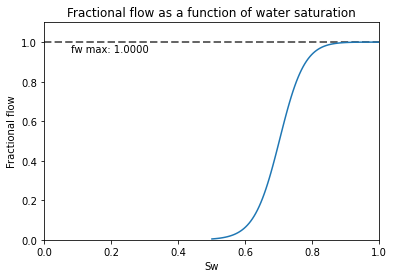

0.9999997771565347


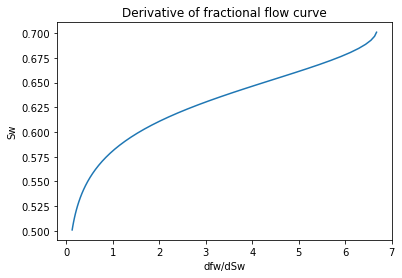

0.500000001

In [12]:
a = BuckleyLev()
a.plot_fractional_flow()
a.plot_fractional_flow_deriv()
a.sw_at_shock_front()

In [13]:
def displacement_plot(self):
    #using the shock front velocity, plot the displacement profile
    v_sh = self.sw_at_shock_front()
    
    y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    x = [self.fractional_flow_deriv(i) for i in y if self.fractional_flow_deriv(i)>v_sh ]
   

    return x
BuckleyLev.displacement_plot = displacement_plot

In [14]:
def rarefaction_plot(self):
    # it should calculate the shock velocity and the corresponding saturation which this occurs an
    
    #create dx window of increasing size for calculating welge
    x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
    
    maximum, sw_shock = 0,0
    grads = []
    
    # to do - add flag to allow BL_time function to calcuate sw values from supplied Xd values
    ## calculate welge gradient at each point until we find the max = shock velocity
    
    for swi in x:
        grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
        # vd = xd/td
        grads.append(grad)
      
        if grad>maximum:
            sw_shock = swi
            maximum = grad
         
    #find the position of the shock velocity in the grads array and slice to this point for the rarefaction 
    #plus one to include the actual shock velocity. Reverse to get the values in the right order
    rarefaction = (grads[:([i for i,j in enumerate(grads) if j == maximum][0]+1)])
    rarefaction.sort(reverse=True)

    y = x[:(len(rarefaction))]
    
    #save calculated grads to instance 
    print(rarefaction[0])
    for v in rarefaction:
        self.params['vd_array'].append(v)
        
    #plot rarefaction part 
    plt.plot(rarefaction,y,'b',lw=2)
    
    #highlight vshock point
    plt.plot(rarefaction[0],y[0],'ro')
    
    #add the part ahead of the shock front
    plt.vlines(rarefaction[0],y[0],self.params["initial_sw"],'b',lw=2)
    plt.hlines(self.params["initial_sw"],rarefaction[0],rarefaction[0]+1,'b',lw=2)

    #add saturation lines
    plt.hlines(self.params["initial_sw"],0,rarefaction[0],linestyles='dashed',lw=2,colors='0.4')
    plt.hlines(y[0],0,rarefaction[0],linestyles='dashed',lw=2, colors='0.4')
    plt.vlines(rarefaction[0],-2,self.params["initial_sw"],linestyles='dashed',lw=2, colors='0.4')

    # add annotations
    plt.annotate('V shock',xy=(rarefaction[0]+0.02,y[0]+0.02))
    plt.annotate('Sw f',xy=(0+0.04,y[0]-0.05))
    plt.annotate('Sw i',xy=(0+0.04,self.params["initial_sw"]-0.05))
    
    
    #ad vdmin if the min velocity values is not zero 
    if (rarefaction[len(rarefaction)-1]>0.001):
        plt.hlines(y[len(y)-1],0,rarefaction[len(rarefaction)-1],'b',lw=2)
        plt.plot(rarefaction[len(rarefaction)-1],y[len(y)-1],'ro')
        plt.annotate('V min',xy=((rarefaction[len(rarefaction)-1]+0.08),(y[len(y)-1])))
        plt.vlines(rarefaction[len(rarefaction)-1],y[len(y)-1],0,linestyles='dashed',lw=2, colors='0.4')
        plt.annotate('Sw c',xy=(0+0.04,1-self.params["residual_o"]+0.03))

    plt.xlabel('Dimensionless Velocity, Vd = xd/td')
    plt.ylabel('Saturation')
    
    plt.ylim([0,1])
    plt.xlim([0,rarefaction[0]+1])
    plt.title('Saturation profile velocity')
    plt.show()
    
    
BuckleyLev.rarefaction_plot = rarefaction_plot

2.4367691397348614


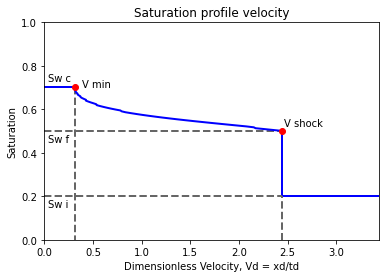

0.500000001

In [15]:
a = BuckleyLev()
a.rarefaction_plot()
a.sw_at_shock_front()

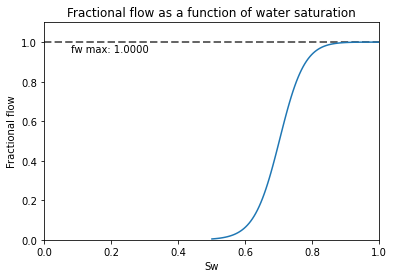

0.9999997771565347


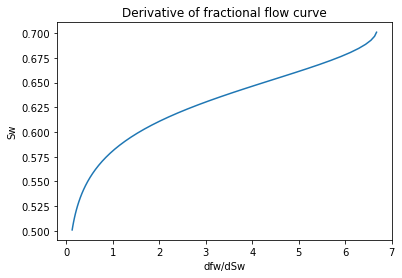

In [16]:
a.plot_fractional_flow()
a.plot_fractional_flow_deriv()

In [17]:
def porevols_plot(self):
    #it should calculate the number of pore volumes injected and plot against td
    
    #calculate pore volumes injected
    Pvi, Swbar = [], []
    for v in self.params['vd_array']:
        pvi.append(1./v)
        
    #calculate average water sats

In [18]:
def BL_time_sol(self,time):
    #it should return a function that returns water saturations when supplied by xd values
    # time is in days
    # q is volumetric flux rate in m3/day.m2
    # A is cross sectional area in m2
    # poro is frac
    
            #grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
    
    sw_at_front = self.sw_at_shock_front()
    sw_deriv_at_front = self.fractional_flow_deriv(sw_at_front)
    print('sw_atfront',(sw_at_front))
    print('vel at front',sw_deriv_at_front)
    #calculate the td based on the time
    td = (time*self.params['inject_rate'])/self.params['poro']*self.params['x-area']
    
    #then use this to calculate the xd at shock front by x with dfw/dsw
    xd_shock = sw_deriv_at_front*td

    print('xd_shock',xd_shock)
    #now work backwards, calculate xd values for each water saturation 
    
    #setup the water saturation array 
    y = np.arange(1.-self.params["residual_o"],sw_at_front,-0.001)
    
    
    np.append(y,sw_at_front)
    #y.append(sw_at_front)
    #print('y',y)
    
    x = [self.fractional_flow_deriv(sw) for sw in y]
    #multiply by td to account for time

    x2 = [xi*td for xi in x]
  
    
    #interpolate will return a function that returns a y for a given x, note x must be monotomically increasing
    #print('x',x,'y',y)
    sat_behind_front = interpolate.interp1d(sorted(x2),y)
    
    #return the function to be called later, note check to see if we are behind the shock front at the given x
    def saturation_at_xd(xd):
        if xd<xd_shock:
            return sat_behind_front(xd)
        else:
            return self.params['initial_sw']
        
    return (saturation_at_xd)

BuckleyLev.BL_time_sol = BL_time_sol

In [19]:
a = BuckleyLev()
b = a.BL_time_sol(3)

b(980)

sw_atfront 0.500000001
vel at front 0.12037124871200518
xd_shock 902.7843653400388


0.2

In [21]:
a.sw_at_shock_front()

0.500000001

# 1.2 Relative permeability models

### Two widely used **relative permeability models** were considered for the Buckley-Leverett (Eq. 1): 


###  a) The Chierici’s relative permeability model 

**Eq. 5**
\begin{equation}
\kappa_{r w}=\kappa_{w}^{0} e^{-B\left(\frac{S_{w}-S_{w 0}}{1-S_{w}-S_{o 0}}\right)^{-M}}
\quad \kappa_{r o}=\kappa_{o}^{0} e^{-A\left(\frac{S_{w}-S_{w 0}}{1-S_{w}-S_{o 0}}\right)^{L}}
\end{equation}

where 

- **A**, **L**, **B** and **M** - parameters for the relative permeabilities

###  b) The LET relative permeability model 

**Eq. 6**
\begin{equation}
\kappa_{r w}=\kappa_{w}^{0} \frac{S_{w e}^{L_{w}}}{S_{w e}^{L_{w}}+E_{w}\left(1-S_{w e}\right)^{T_{w}}} \quad \kappa_{r o}=\kappa_{o}^{0} \frac{\left(1-S_{w e}\right)^{L_{o}}}{\left(1-S_{w e}\right)^{L_{o}}+E_{o} S_{w e}^{T_{o}}}
\end{equation}

where 

- **Lw**, **Ew**, **Tw**, **Lo**, **Eo**, and **To** - parameters of the model  (**w** - water phase and **o** - oil phase)

**Swe** - effective water saturation calculated as:

**Eq. 7**

\begin{equation}
S_{w e}=\frac{S_{w}-S_{w 0}}{1-S_{w 0}-S_{o 0}}
\end{equation}

where 

- **Sw0** - connate water saturation, 

- **So0** the residual oil saturation, 

- **𝜅0o** - oil relative permeability at the connate water saturation, 

- **𝜅0𝑤** - water relative permeability at the residual oil saturation

# 1.3 Datasets 

!разобраться откуда какие данные!

# 1.4 Input parameters and quantities of interest

To perform UQ and SA studies we must define a set of input parameters θ and relevant **quantities of interest (QoIs)**:

### a) For Chierici’s model the input parameters:

\begin{equation}
θ_{c}={({B; M; A; L})}
\end{equation}

### b) For LET model the input parameters:

\begin{equation}
θ_{c}={({L_{w},E_{w},T_{w},L_{o},E_{o},T_{o}})}
\end{equation}

### The following **QoIs** were considered in this study: 

**Scpt** - relative permeability crossing point, 

**Eq. 8**

\begin{equation}
\kappa_{r w}\left(S_{c p t}\right)-\kappa_{r o}\left(S_{c p t}\right)=0
\end{equation}

**S𝑓** -shock front saturation,

**Eq. 9**

\begin{equation}
\frac{\partial f\left(S_{f}\right)}{\partial S_{w}}\left(S_{f}-S_{w 0}\right)-f\left(S_{f}\right)=0
\end{equation}


**V(t)** - displaced oil at a fixed time

**Eq. 10**

\begin{equation}
V(t)=a \int_{0}^{t} q\left(1-f\left(S_{w}(L, \tau)\right)\right) d \tau
\end{equation}

where 

- **f(Sw(L,𝜏)** - fractional flow function evaluated at any time instant **τ** and at the position **x=L** which, corresponds to the size of the core sample.

The datasets and the simulations performed in this work focus on core-scale experiments. QoIs used in this work were chosen considering their relevance to both core-scale and field-scale experiments. For instance, the crossing point saturation **Scpt** and the shock front saturation **S𝑓** are essential indicators of the performance for both mature or new reservoirs.

# 1.5 Parameter and distribution estimation

For each relative permeability model (Chierici and LET) we performed a parameter estimation based on the presented datasets using the **Markov Chain Monte Carlo (MCMC) method**. 

**(MCMC implemented in emcee library, implemented in the lmfit package, was used to obtain an initial guess for the relative permeability model parameters required for the MCMC).**

### Assuming θ as the relative permeability model parameters and D as the dataset, MCMC tries to estimate:

**Eq. 11**

\begin{equation}
\mathbb{P}(\boldsymbol{\theta} \mid D)=\frac{\mathbb{P}(\boldsymbol{D} \mid \boldsymbol{\theta}) \mathbb{P}(\boldsymbol{\theta})}{\mathbb{P}(D)}
\end{equation}

where 

- **ℙ(𝜽)** - prior knowledge about the input parameters **θ** - joint probability distribution, 

- **ℙ(𝑫∣𝜽)** - likelihood function, 

- **ℙ(𝐷)** - evidence that the data was generated by this model. 

In **Eq. 11** - likelihood function:

**Eq. 12**

\begin{equation}
\ln (\mathbb{P}(D \mid \boldsymbol{\theta}))=-0.5 \sum_{i}^{N_{d}}\left[\left(\frac{D^{i}-y^{i}(\boldsymbol{\theta})}{\sigma^{i}}\right)^{2}+2 \log \left(\sigma^{i}\right)\right]
\end{equation}

where 

- **Nd** - size of the dataset, 

- **𝜎𝑖** represents the error values, 

- **𝑦𝑖(𝜽)** - entry of the vector representing the relative permeability model evaluated at the sample parameters **θ**.

The MCMC method requires the definition of a prior distribution - **flat prior distributions:**

**Eq. 13**

\begin{equation}
\ln (\mathbb{P}(\boldsymbol{\theta}))=\{\text { 0if all entries of } \boldsymbol{\theta} \in \mathbb{R}>0
\end{equation}

-∞ elsewhere.

# 2.1 Uncertainty quantification

# 3.1 Sensitivity analysis

In [ ]:
#pip install SAlib

def function(x,y,z,sw,s0):
    """
    main function
    
    """
    return results

